# **HMM-based Part-of-Speech Tagging**

- **Goal**: Implement POS tagging by HMM model
- **Data**:

    NLTK Penn Treebank for evalation dataset

    CORD-19 for application corpus

- **Framework**: Pycharm

## Link to dataset


In [1]:
from google.colab import drive
import os, shutil

drive.mount('/content/drive')

metadata_csv = "/content/drive/MyDrive/metadata.csv"
assert os.path.exists(metadata_csv), f"Not found: {metadata_csv}"

# Just want to read faster
local_csv = "/content/metadata.csv"
if not os.path.exists(local_csv):
    shutil.copyfile(metadata_csv, local_csv)

print("Using:", local_csv, "size(bytes)=", os.path.getsize(local_csv))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using: /content/metadata.csv size(bytes)= 1648942196


## Setup

In [2]:
import argparse
import os
import csv
import json
import math
import random
from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import treebank


# Defaults
DEFAULT_SEED = 42

# Required by your group
DEFAULT_SPLIT_TRAIN = 0.70
DEFAULT_SPLIT_DEV = 0.10
DEFAULT_SPLIT_TEST = 0.20

# CORD-19 reading limits
DEFAULT_MAX_ROWS = 20000
DEFAULT_MAX_SENTENCES = 50000
DEFAULT_MIN_TOKENS = 2

# HMM params
DEFAULT_ADDK = 0.001
DEFAULT_UNK_THRESHOLD = 0

START = "<s>"
END = "</s>"
UNK = "<UNK>"


# Utils
def ensure_nltk():
    for pkg, path in [
        ("punkt", "tokenizers/punkt"),
        ("punkt_tab", "tokenizers/punkt_tab"),
        ("treebank", "corpora/treebank"),
    ]:
        try:
            nltk.data.find(path)
        except LookupError:
            nltk.download(pkg)


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)


def safe_mkdir(path: str):
    os.makedirs(path, exist_ok=True)


## Split

In [3]:
def deterministic_split(items: List, train_ratio: float, dev_ratio: float, test_ratio: float, seed: int):
    total = train_ratio + dev_ratio + test_ratio
    if abs(total - 1.0) > 1e-8:
        raise ValueError(f"Split ratios must sum to 1. Got {total}")

    rng = random.Random(seed)
    idx = list(range(len(items)))
    rng.shuffle(idx)

    n = len(items)
    n_train = int(n * train_ratio)
    n_dev = int(n * dev_ratio)

    train = [items[i] for i in idx[:n_train]]
    dev = [items[i] for i in idx[n_train:n_train + n_dev]]
    test = [items[i] for i in idx[n_train + n_dev:]]
    return train, dev, test


# CORD-19

In [4]:
# CORD-19
def read_metadata_csv_chunked(path: str, use_fields, max_rows=None):
    texts = []
    if not os.path.exists(path):
        raise FileNotFoundError(f"metadata_csv not found: {path}")

    chunk_size = 5000 if max_rows is None else min(5000, max_rows)
    rows = 0

    for chunk in pd.read_csv(
        path,
        usecols=use_fields,
        chunksize=chunk_size,
        low_memory=False,
        on_bad_lines="skip",
    ):
        chunk = chunk.fillna("").astype(str)

        combined = chunk[use_fields].agg(" ".join, axis=1).str.strip()
        combined = combined[combined != ""]
        texts.extend(combined.tolist())

        rows += len(chunk)
        if max_rows is not None and rows >= max_rows:
            break

    if max_rows is not None:
        texts = texts[:max_rows]
    return texts



def build_sentences_from_texts(texts: List[str], max_sentences: int, min_tokens: int) -> List[List[str]]:
    sentences: List[List[str]] = []
    for t in texts:
        for s in sent_tokenize(t):
            tokens = word_tokenize(s)
            if len(tokens) < min_tokens:
                continue
            sentences.append(tokens)
            if max_sentences is not None and len(sentences) >= max_sentences:
                return sentences
    return sentences

In [5]:
pred_path = "outputs/hmm/cord19_hmm_predictions.tsv"
df = pd.read_csv(pred_path, sep="\t")

df.head(30)


,sent_id,token_index,token,pred_tag
0,0,0,Clinical,``
1,0,1,features,NNS
2,0,2,of,IN
3,0,3,culture-proven,PRP
4,0,4,Mycoplasma,MD
5,0,5,pneumoniae,VB
6,0,6,infections,RP
7,0,7,at,IN
8,0,8,King,PDT
9,0,9,Abdulaziz,DT


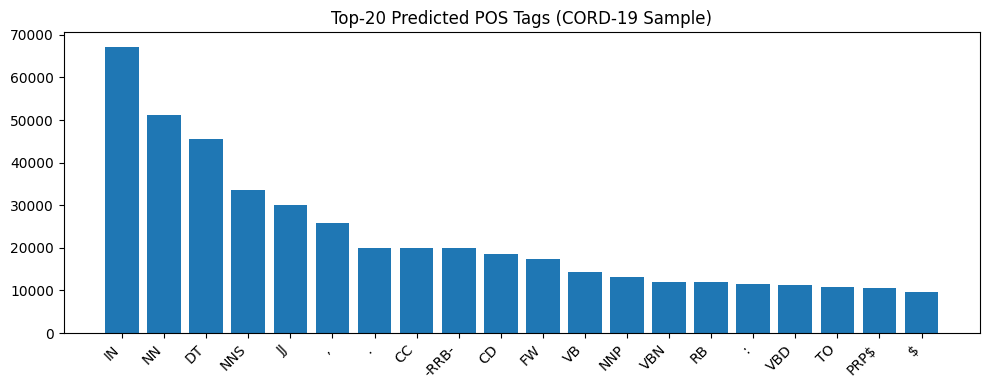

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

tag_counts_cord = Counter(df["pred_tag"])
top = tag_counts_cord.most_common(20)

plt.figure(figsize=(10,4))
plt.bar([t for t,_ in top], [c for _,c in top])
plt.xticks(rotation=45, ha="right")
plt.title("Top-20 Predicted POS Tags (CORD-19 Sample)")
plt.tight_layout()
plt.show()


## HMM Model Part

In [7]:
# HMM
@dataclass
class HMMModel:
    tags: List[str]
    vocab: set
    log_trans: Dict[str, Dict[str, float]]
    log_emit: Dict[str, Dict[str, float]]
    log_emit_unk: Dict[str, float]


def normalize_word(w: str) -> str:
    return w


def train_bigram_hmm(tagged_sents: List[List[Tuple[str, str]]], add_k: float, unk_threshold: int) -> HMMModel:
    word_counts = Counter()
    for sent in tagged_sents:
        for w, _t in sent:
            word_counts[normalize_word(w)] += 1

    def map_word(w: str) -> str:
        w2 = normalize_word(w)
        return UNK if word_counts[w2] <= unk_threshold else w2

    tag_counts = Counter()
    trans_counts = defaultdict(Counter)
    emit_counts = defaultdict(Counter)

    for sent in tagged_sents:
        prev = START
        tag_counts[prev] += 1

        for w, t in sent:
            w_m = map_word(w)
            tag_counts[t] += 1
            trans_counts[prev][t] += 1
            emit_counts[t][w_m] += 1
            prev = t

        trans_counts[prev][END] += 1
        tag_counts[END] += 1

    tags = sorted([t for t in tag_counts.keys() if t not in (START, END)])
    vocab = set()
    for t in emit_counts:
        vocab.update(emit_counts[t].keys())
    vocab.add(UNK)

    # transitions
    log_trans: Dict[str, Dict[str, float]] = {}
    all_next = tags + [END]
    for prev_tag, next_counter in trans_counts.items():
        log_trans[prev_tag] = {}
        total = sum(next_counter.values())
        denom = total + add_k * len(all_next)
        for nxt in all_next:
            num = next_counter.get(nxt, 0) + add_k
            log_trans[prev_tag][nxt] = math.log(num / denom)

    # emissions
    log_emit: Dict[str, Dict[str, float]] = {}
    log_emit_unk: Dict[str, float] = {}
    for t in tags:
        counter = emit_counts.get(t, Counter())
        total = sum(counter.values())
        denom = total + add_k * len(vocab)

        log_emit[t] = {}
        for w, c in counter.items():
            log_emit[t][w] = math.log((c + add_k) / denom)

        c_unk = counter.get(UNK, 0)
        log_emit_unk[t] = math.log((c_unk + add_k) / denom)

    return HMMModel(tags=tags, vocab=vocab, log_trans=log_trans, log_emit=log_emit, log_emit_unk=log_emit_unk)


def viterbi_decode(tokens: List[str], model: HMMModel) -> List[str]:
    tags = model.tags
    n = len(tokens)
    if n == 0:
        return []

    dp: List[Dict[str, float]] = [defaultdict(lambda: -1e18) for _ in range(n)]
    bp: List[Dict[str, str]] = [{} for _ in range(n)]

    w0 = normalize_word(tokens[0])
    w0 = w0 if w0 in model.vocab else UNK
    for t in tags:
        trans = model.log_trans.get(START, {}).get(t, -1e18)
        emit = model.log_emit[t].get(w0, model.log_emit_unk[t])
        dp[0][t] = trans + emit
        bp[0][t] = START

    for i in range(1, n):
        wi = normalize_word(tokens[i])
        wi = wi if wi in model.vocab else UNK

        for t in tags:
            emit = model.log_emit[t].get(wi, model.log_emit_unk[t])
            best_score = -1e18
            best_prev = tags[0]

            for prev in tags:
                score = dp[i - 1][prev] + model.log_trans.get(prev, {}).get(t, -1e18) + emit
                if score > best_score:
                    best_score = score
                    best_prev = prev

            dp[i][t] = best_score
            bp[i][t] = best_prev

    best_last = tags[0]
    best_last_score = -1e18
    for t in tags:
        score = dp[n - 1][t] + model.log_trans.get(t, {}).get(END, -1e18)
        if score > best_last_score:
            best_last_score = score
            best_last = t

    path = [best_last]
    for i in range(n - 1, 0, -1):
        path.append(bp[i][path[-1]])
    path.reverse()
    return path


## PTB Evaluation

In [8]:
def token_accuracy(y_true: List[str], y_pred: List[str]) -> float:
    if not y_true:
        return 0.0
    return sum(1 for a, b in zip(y_true, y_pred) if a == b) / len(y_true)


def save_confusion_matrix_png(y_true, y_pred, out_path: str, max_labels: int = 40, normalize: bool = False):
    from collections import Counter
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    labels_all = list(set(y_true) | set(y_pred))
    if len(labels_all) > max_labels:
        freq = Counter(y_true)
        labels = [x for x, _ in freq.most_common(max_labels)]
        filt_true, filt_pred = [], []
        for t, p in zip(y_true, y_pred):
            if t in labels and p in labels:
                filt_true.append(t)
                filt_pred.append(p)
        y_true, y_pred = filt_true, filt_pred
        labels_all = labels

    labels_all = sorted(labels_all)
    cm = confusion_matrix(y_true, y_pred, labels=labels_all).astype(float)

    if normalize:
        row_sum = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, row_sum, where=row_sum != 0)

    fig, ax = plt.subplots(figsize=(12, 10), facecolor="white")
    ax.set_facecolor("white")
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title("Confusion Matrix (HMM on PTB Test)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Gold (PTB)")
    ax.set_xticks(range(len(labels_all)))
    ax.set_yticks(range(len(labels_all)))
    ax.set_xticklabels(labels_all, rotation=90, fontsize=8)
    ax.set_yticklabels(labels_all, fontsize=8)

    plt.tight_layout()
    plt.savefig(out_path, dpi=200, facecolor="white")
    plt.close(fig)



def evaluate_hmm_on_ptb(
    seed: int,
    train_ratio: float,
    dev_ratio: float,
    test_ratio: float,
    add_k: float,
    unk_threshold: int,
    out_dir: str
) -> Dict:
    ptb = treebank.tagged_sents()  # gold PTB tags
    ptb_items = list(range(len(ptb)))
    train_ids, dev_ids, test_ids = deterministic_split(ptb_items, train_ratio, dev_ratio, test_ratio, seed)

    print("PTB sizes:", len(ptb), "train/dev/test:", len(train_ids), len(dev_ids), len(test_ids))
    print("Overlap train-test:", len(set(train_ids) & set(test_ids)))
    print("Overlap train-dev :", len(set(train_ids) & set(dev_ids)))
    print("Overlap dev-test  :", len(set(dev_ids) & set(test_ids)))

    train_sents = [ptb[i] for i in train_ids]
    dev_sents = [ptb[i] for i in dev_ids]
    test_sents = [ptb[i] for i in test_ids]

    model = train_bigram_hmm(train_sents, add_k=add_k, unk_threshold=unk_threshold)

    y_true: List[str] = []
    y_pred: List[str] = []

    # decode PTB test
    printed = False
    for sent in test_sents:
        words = [w for w, t in sent]
        gold = [t for w, t in sent]
        pred = viterbi_decode(words, model)

        if not printed:
            print("LEN words:", len(words), "LEN pred:", len(pred), "LEN gold:", len(gold))
            print("WORDS:", words[:10])
            print("PRED :", pred[:10])
            print("GOLD :", gold[:10])
            print("pred==gold for this sentence?", pred == gold)
            printed = True

        y_true.extend(gold)
        y_pred.extend(pred)

    acc = token_accuracy(y_true, y_pred)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # save confusion matrix
    cm_path = os.path.join(out_dir, "ptb_confusion_matrix.png")
    save_confusion_matrix_png(y_true, y_pred, cm_path, max_labels=40)

    # save a small sample for report
    sample_path = os.path.join(out_dir, "ptb_predictions_sample.tsv")
    with open(sample_path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["sent_idx_in_test", "token_index", "token", "gold_tag", "pred_tag"])
        for si, sent in enumerate(test_sents[:50]):
            words = [w0 for w0, _ in sent]
            gold = [t0 for _, t0 in sent]
            pred = viterbi_decode(words, model)
            for ti, (tok, g, p) in enumerate(zip(words, gold, pred)):
                w.writerow([si, ti, tok, g, p])

    report = {
    "dataset": "PTB (NLTK treebank)",
    "split": {"train": train_ratio, "dev": dev_ratio, "test": test_ratio},
    "seed": seed,
    "hmm": {"order": 2, "add_k": add_k, "unk_threshold": unk_threshold},
    "metrics": {"token_accuracy": acc, "macro_f1": macro, "num_tokens": len(y_true)},
    "artifacts": {
        "confusion_matrix_png": cm_path,
        "predictions_sample_tsv": sample_path
        }
    }
    return report, model, y_true, y_pred

def print_top_confusions(y_true, y_pred, topk=20):
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    pairs = []
    for i, gt in enumerate(labels):
        for j, pr in enumerate(labels):
            if i != j and cm[i, j] > 0:
                pairs.append((cm[i, j], gt, pr))

    pairs.sort(reverse=True)
    print("\n[Top Confusions] (count, GOLD -> PRED)")
    for c, gt, pr in pairs[:topk]:
        print(f"{c:6d}  {gt:>6} -> {pr:<6}")


def infer_on_cord19(
    model: HMMModel,
    metadata_csv: str,
    out_dir: str,
    use_fields: List[str],
    max_rows: int,
    max_sentences: int
):
    texts = read_metadata_csv_chunked(metadata_csv, use_fields=use_fields, max_rows=max_rows)
    sents = build_sentences_from_texts(texts, max_sentences=max_sentences, min_tokens=DEFAULT_MIN_TOKENS)

    out_path = os.path.join(out_dir, "cord19_hmm_predictions.tsv")
    with open(out_path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["sent_id", "token_index", "token", "pred_tag"])
        for sid, toks in enumerate(sents):
            tags = viterbi_decode(toks, model)
            for i, (tok, tag) in enumerate(zip(toks, tags)):
                w.writerow([sid, i, tok, tag])

    print(f"[INFO] CORD-19 inference done. Saved: {out_path}")

## Output Templates

In [9]:
def run_experiment(
    out_dir: str = "outputs/hmm",
    seed: int = 42,
    train_ratio: float = 0.70,
    dev_ratio: float = 0.10,
    test_ratio: float = 0.20,
    add_k: float = 0.001,
    unk_threshold: int = 0,
    metadata_csv: Optional[str] = None,
    use_fields: Optional[List[str]] = None,
    max_rows: int = 20000,
    max_sentences: int = 20000,
):
    ensure_nltk()
    set_seed(seed)
    safe_mkdir(out_dir)

    ptb_report, hmm_model, y_true, y_pred = evaluate_hmm_on_ptb(
        seed=seed,
        train_ratio=train_ratio,
        dev_ratio=dev_ratio,
        test_ratio=test_ratio,
        add_k=add_k,
        unk_threshold=unk_threshold,
        out_dir=out_dir
    )

    metrics_path = os.path.join(out_dir, "ptb_metrics.json")
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(ptb_report, f, indent=2)

    if metadata_csv:
        if use_fields is None:
            use_fields = ["title", "abstract"]
        infer_on_cord19(
            model=hmm_model,
            metadata_csv=metadata_csv,
            out_dir=out_dir,
            use_fields=use_fields,
            max_rows=max_rows,
            max_sentences=max_sentences
        )

    return ptb_report, hmm_model, y_true, y_pred

# Results Show & Save

In [10]:
ptb_report, hmm_model, y_true, y_pred = run_experiment(
    out_dir="outputs/hmm",
    seed=42,
    train_ratio=0.7,
    dev_ratio=0.1,
    test_ratio=0.2,
    add_k=0.001,
    unk_threshold=0,
    metadata_csv=None,
    use_fields=["title", "abstract"],
    max_rows=20000,
    max_sentences=20000
)

PTB sizes: 3914 train/dev/test: 2739 391 784
Overlap train-test: 0
Overlap train-dev : 0
Overlap dev-test  : 0
LEN words: 19 LEN pred: 19 LEN gold: 19
WORDS: ['The', 'report', 'from', 'the', 'Fed', 'found', 'that', 'manufacturing', ',', 'in']
PRED : ['DT', 'NN', 'IN', 'DT', 'NNP', 'VBD', 'IN', 'NN', ',', 'IN']
GOLD : ['DT', 'NN', 'IN', 'DT', 'NNP', 'VBD', 'IN', 'NN', ',', 'IN']
pred==gold for this sentence? True


PTB Metrics


In [11]:
df_metrics = pd.DataFrame([{
    "token_accuracy": ptb_report["metrics"]["token_accuracy"],
    "macro_f1": ptb_report["metrics"]["macro_f1"],
    "num_tokens": ptb_report["metrics"]["num_tokens"],
    "add_k": ptb_report["hmm"]["add_k"],
    "unk_threshold": ptb_report["hmm"]["unk_threshold"],
    "seed": ptb_report["seed"],
    "split_train": ptb_report["split"]["train"],
    "split_dev": ptb_report["split"]["dev"],
    "split_test": ptb_report["split"]["test"],
}])

df_metrics


,token_accuracy,macro_f1,num_tokens,add_k,unk_threshold,seed,split_train,split_dev,split_test
0,0.908407,0.720878,19674,0.001,0,42,0.7,0.1,0.2


Confusion Matrix

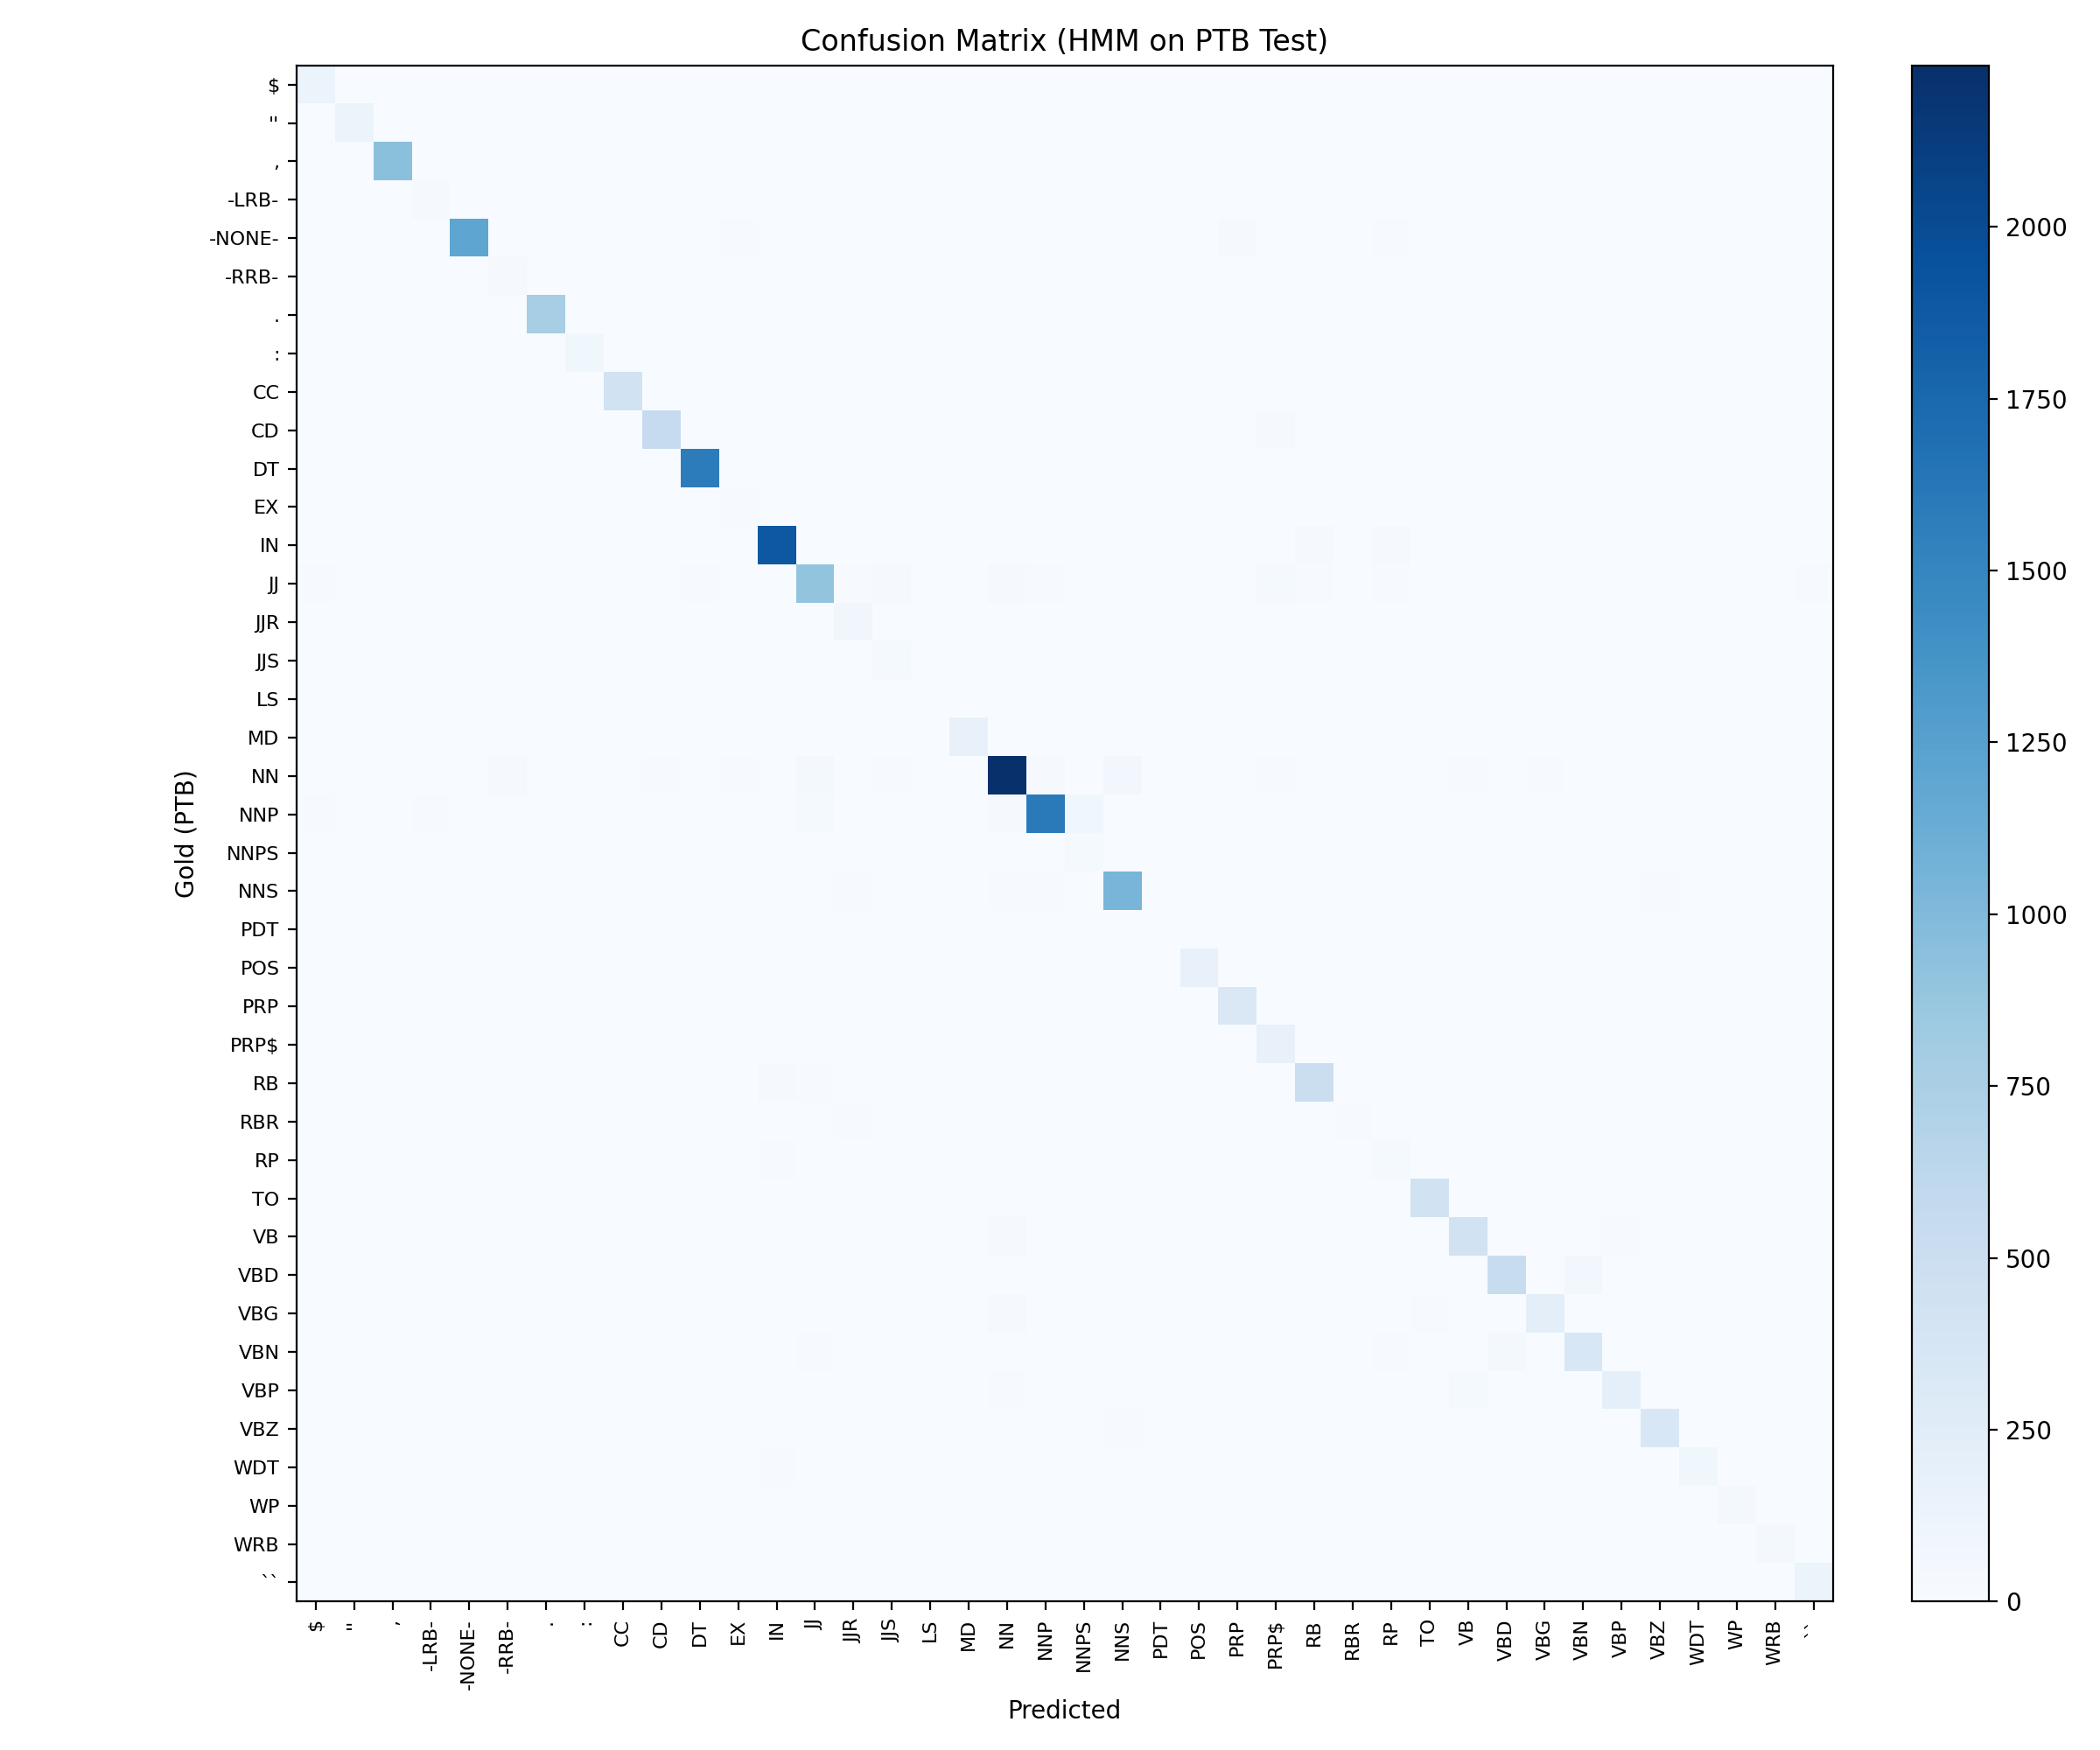

In [12]:
from IPython.display import Image, display

cm_path = ptb_report["artifacts"]["confusion_matrix_png"]
display(Image(filename=cm_path))


Top Confusions

In [13]:
from sklearn.metrics import confusion_matrix
from collections import Counter

def top_confusions_df(y_true, y_pred, topk=20):
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    rows = []
    for i, gt in enumerate(labels):
        for j, pr in enumerate(labels):
            if i != j and cm[i, j] > 0:
                rows.append((cm[i, j], gt, pr))
    rows.sort(reverse=True)
    return pd.DataFrame(rows[:topk], columns=["count", "gold", "pred"])

top_confusions_df(y_true, y_pred, topk=20)

,count,gold,pred
0,80,NNP,NNPS
1,54,NN,NNS
2,53,VBD,VBN
3,50,NN,JJ
4,45,VBN,VBD
5,28,VBP,VB
6,28,NNP,JJ
7,28,JJ,PRP$
8,26,NN,-RRB-
9,26,JJ,NN


Tag Distribution

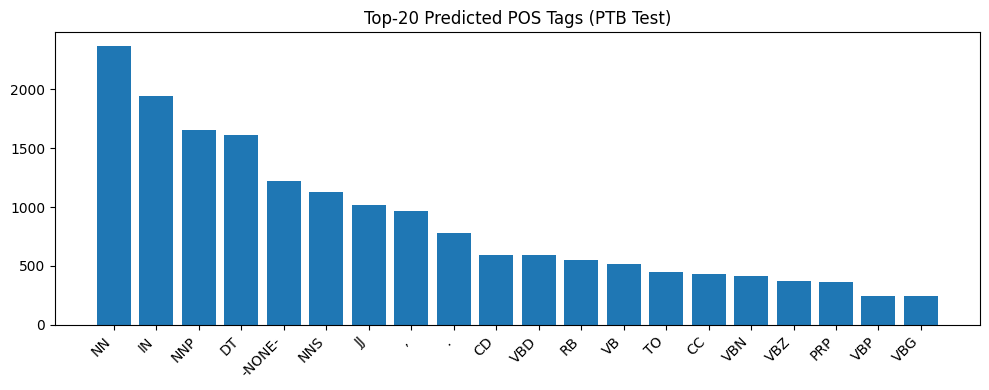

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

tag_counts = Counter(y_pred)
top = tag_counts.most_common(20)

plt.figure(figsize=(10,4))
plt.bar([t for t,_ in top], [c for _,c in top])
plt.xticks(rotation=45, ha="right")
plt.title("Top-20 Predicted POS Tags (PTB Test)")
plt.tight_layout()
plt.show()


## CORD-19 Inference

In [15]:
OUT_DIR = "outputs/hmm"
os.makedirs(OUT_DIR, exist_ok=True)

infer_on_cord19(
    model=hmm_model,
    metadata_csv=local_csv,
    out_dir="outputs/hmm",
    use_fields=["title","abstract"],
    max_rows=20000,
    max_sentences=20000
)

[INFO] CORD-19 inference done. Saved: outputs/hmm/cord19_hmm_predictions.tsv


In [16]:
OUT_DIR = "outputs/hmm"
print("Files in", OUT_DIR)
for fn in sorted(os.listdir(OUT_DIR)):
    path = os.path.join(OUT_DIR, fn)
    size_mb = os.path.getsize(path) / (1024*1024)
    print(f"- {fn}  ({size_mb:.2f} MB)")


Files in outputs/hmm
- cord19_hmm_predictions.tsv  (9.95 MB)
- cord19_hmm_predictions_filtered.tsv  (6.22 MB)
- ptb_confusion_matrix.png  (0.12 MB)
- ptb_metrics.json  (0.00 MB)
- ptb_predictions_sample.tsv  (0.02 MB)


In [17]:
pred_path = "outputs/hmm/cord19_hmm_predictions.tsv"
df = pd.read_csv(pred_path, sep="\t")

df.head(30)
print("Num rows:", len(df))
print("Num sentences:", df["sent_id"].nunique())
print("Avg tokens/sent:", len(df) / df["sent_id"].nunique())
print("Unique tags:", df["pred_tag"].nunique())


Num rows: 559902
Num sentences: 20000
Avg tokens/sent: 27.9951
Unique tags: 45


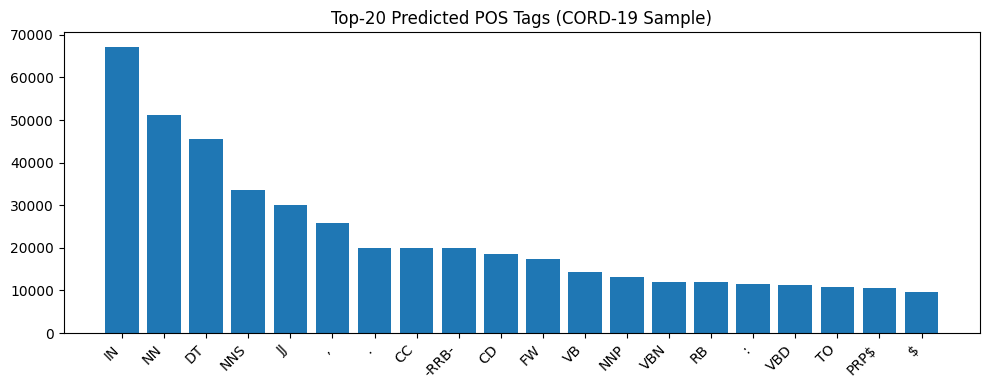

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

tag_counts = Counter(df["pred_tag"])
top = tag_counts.most_common(20)

plt.figure(figsize=(10,4))
plt.bar([t for t,_ in top], [c for _,c in top])
plt.xticks(rotation=45, ha="right")
plt.title("Top-20 Predicted POS Tags (CORD-19 Sample)")
plt.tight_layout()
plt.show()


## Filter Prediction

In [19]:
OUT_DIR = "outputs/hmm"
full_path = f"{OUT_DIR}/cord19_hmm_predictions.tsv"
filt_path = f"{OUT_DIR}/cord19_hmm_predictions_filtered.tsv"

cord_full_df = pd.read_csv(full_path, sep="\t")
cord_filt_df = pd.read_csv(filt_path, sep="\t")

print("full rows:", len(cord_full_df), "filtered rows:", len(cord_filt_df))
cord_filt_df.head()

full rows: 559902 filtered rows: 348014


,sent_id,token_index,token,pred_tag
0,0,0,Clinical,``
1,0,1,features,NNS
2,0,4,Mycoplasma,MD
3,0,5,pneumoniae,VB
4,0,6,infections,RP


In [20]:
from collections import Counter

OUT_DIR = "outputs/hmm"
full_path = f"{OUT_DIR}/cord19_hmm_predictions.tsv"
df_full = pd.read_csv(full_path, sep="\t")

min_token_freq = 10
max_token_ratio = 0.01  # 1%
token_counts = df_full["token"].astype(str).str.lower().value_counts()
max_token_freq = max(1, int(len(df_full) * max_token_ratio))

keep_tokens = set(token_counts[(token_counts >= min_token_freq) & (token_counts <= max_token_freq)].index)
print("keep_tokens:", len(keep_tokens), "max_token_freq:", max_token_freq)

df_filt = df_full[df_full["token"].astype(str).str.lower().isin(keep_tokens)].copy()
filtered_path = f"{OUT_DIR}/cord19_hmm_predictions_filtered.tsv"
df_filt.to_csv(filtered_path, sep="\t", index=False)
print("Saved:", filtered_path, "rows:", len(df_filt))

keep_tokens: 4967 max_token_freq: 5599
Saved: outputs/hmm/cord19_hmm_predictions_filtered.tsv rows: 348014


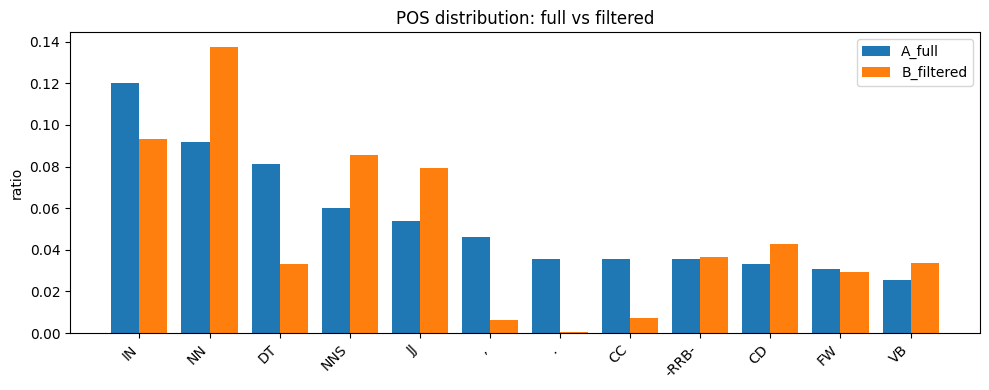

In [21]:
import matplotlib.pyplot as plt

def pos_ratio(df):
    vc = df["pred_tag"].value_counts(normalize=True)
    return vc

r_full = pos_ratio(df_full)
r_filt = pos_ratio(df_filt)

top_tags = (r_full.sort_values(ascending=False).head(12).index.tolist())
x = range(len(top_tags))
vals_full = [r_full.get(t, 0) for t in top_tags]
vals_filt = [r_filt.get(t, 0) for t in top_tags]

plt.figure(figsize=(10,4))
plt.bar([i-0.2 for i in x], vals_full, width=0.4, label="A_full")
plt.bar([i+0.2 for i in x], vals_filt, width=0.4, label="B_filtered")
plt.xticks(list(x), top_tags, rotation=45, ha="right")
plt.ylabel("ratio")
plt.title("POS distribution: full vs filtered")
plt.legend()
plt.tight_layout()
plt.show()


Proxy-confidence

In [22]:
import numpy as np

def hmm_token_confidence_proxy(model, token: str) -> float:
    """
    Proxy confidence using START->tag prior + emission(tag->token).
    Returns max softmax probability across tags.
    """
    w = normalize_word(token)
    w = w if w in model.vocab else UNK

    scores = []
    for t in model.tags:
        prior = model.log_trans.get(START, {}).get(t, -1e18)
        emit = model.log_emit[t].get(w, model.log_emit_unk[t])
        scores.append(prior + emit)

    scores = np.array(scores, dtype=np.float64)
    m = scores.max()
    probs = np.exp(scores - m)
    probs = probs / probs.sum()
    return float(probs.max())

cord_filt_df["confidence"] = cord_filt_df["token"].astype(str).apply(lambda x: hmm_token_confidence_proxy(hmm_model, x))
cord_filt_df[["token", "pred_tag", "confidence"]].head(20)


,token,pred_tag,confidence
0,Clinical,``,0.192036
1,features,NNS,0.965607
2,Mycoplasma,MD,0.192036
3,pneumoniae,VB,0.192036
4,infections,RP,0.192036
5,at,IN,0.999861
6,University,NNP,0.998562
7,Hospital,NNP,0.976124
8,Saudi,NNP,0.991907
9,Arabia,NNP,0.991907


Confidence Distribution

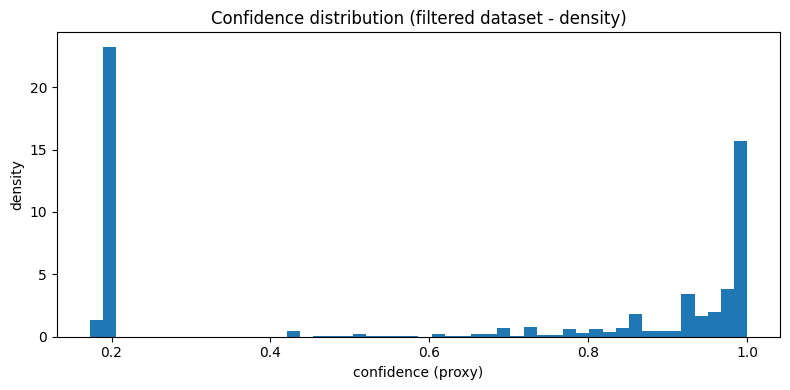

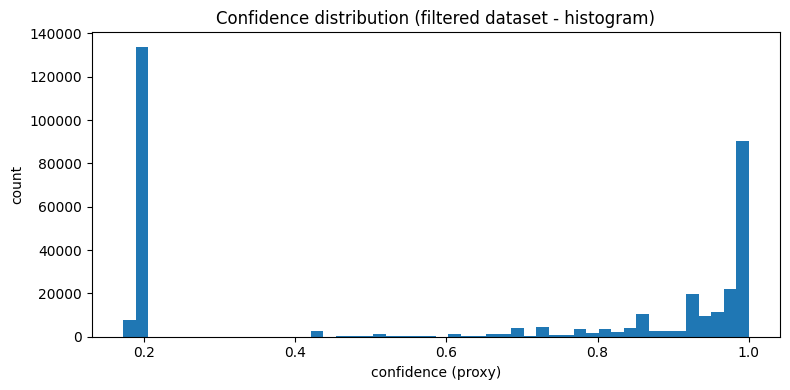

In [23]:
import matplotlib.pyplot as plt

conf = cord_filt_df["confidence"].values

plt.figure(figsize=(8,4))
plt.hist(conf, bins=50, density=True)
plt.xlabel("confidence (proxy)")
plt.ylabel("density")
plt.title("Confidence distribution (filtered dataset - density)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(conf, bins=50, density=False)
plt.xlabel("confidence (proxy)")
plt.ylabel("count")
plt.title("Confidence distribution (filtered dataset - histogram)")
plt.tight_layout()
plt.show()
